In [1]:
# Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import seaborn as sns


# Lab 4: Fire and Tree Mortality

# About the data
Wildfires are increasingly frequent and severe due to climate change. Predicting tree mortality following a wildfire is critical for forest management, ecosystem recovery, and carbon sequestration planning. In this lab, we will build a logistic regression model to predict the probability of tree mortality one year after a wildfire

The database we'll be working with today includes observations of individual trees involved in prescribed fires and wildfires occurring over 35 years, from 1981 to 2016. It is drawn from a fire and tree mortality database from the US Forest Service (see data description for the full database here: [link](https://www.nature.com/articles/s41597-020-0522-7#Sec10)).

The target variable we'll use is `yr1status`, which is a binary variable (0=alive, 1=dead).  This tells us if a tree has died one year after a fire event.

The features we'll use are `YrFireName`, `Times_burned`, `Species`, `Genus_species`,
    `DBH_cm`, `HT_m`, `CR_pre`, and `CR_post`.

## Step 1: Check the metadata

Look at the metadata and provide a description on what each variable represents in the Description column below.


| Feature                     | Description                                                                                   |
|-----------------------------|-----------------------------------------------------------------------------------------------| 
| yr1status                   | Tree status in year 1 post-fire. (0=alive, 1=dead).
| YrFireName                  | A unique identifier for each fire event that includes the year of the fire and the fire name                                  
| Times_burned                | The number of times this tree was burned.                                            
| Species                     | Symbol for species.                                                    
| Genus_species               | Genus and species of the tree assessed in the FTM database.  
| DBH_cm                      | Diameter at breast height rounded to nearest 0.1 cm (cm = centimeters).
| HT_m                        | Pre-fire tree height rounded to nearest 0.01 m (m=meters).
| CR_pre                      | Pre-fire live crown ratio.
| CR_post                     | Post-fire live crown ratio.

## Step 2: Fetch  data
Read in the data set and filter to retain only the variables of interest.  Then check for incomplete observations and remove any rows containing NaNs.  How many observations does that leave us with? **Print your answer.**

In [2]:
# Load the dataset
trees_dat = pd.read_csv('/courses/EDS232/Data/FTM_trees.csv', low_memory = False)

trees_dat = trees_dat[["yr1status", "YrFireName", "Times_burned", "Species", "Genus_species",
    "DBH_cm", "HT_m", "CR_pre", "CR_post"]].dropna()

print(f"We have {trees_dat.shape[0]} observations in the cleanded dataframe.")

We have 36509 observations in the cleanded dataframe.


In [3]:
print(trees_dat.head())
print(f"Data types:\n {trees_dat.dtypes}")

     yr1status    YrFireName  Times_burned Species   Genus_species  DBH_cm  \
500        0.0  2003 - Griff             1    ABAM  Abies_amabilis  71.374   
501        0.0  2003 - Griff             1    ABAM  Abies_amabilis  23.622   
502        0.0  2003 - Griff             1    ABAM  Abies_amabilis  46.228   
503        0.0  2003 - Griff             1    ABAM  Abies_amabilis  21.082   
504        0.0  2003 - Griff             1    ABAM  Abies_amabilis  24.384   

      HT_m  CR_pre  CR_post  
500  41.76    0.84     0.74  
501  12.80    0.60     0.57  
502  34.75    0.75     0.59  
503  23.16    0.38     0.38  
504  26.21    0.42     0.42  
Data types:
 yr1status        float64
YrFireName        object
Times_burned       int64
Species           object
Genus_species     object
DBH_cm           float64
HT_m             float64
CR_pre           float64
CR_post          float64
dtype: object


## Step 3: Data Preprocessing
1. We recode categorical predictors to zero-based integer form because most machine learning models, including logistic regression, cannot work directly with categorical data represented as strings or labels. Instead, models require numerical input. Let's do that here. 


In [4]:
# Recode categorical predictors to integers
le = LabelEncoder()
objects = ["YrFireName", "Species", "Genus_species"]
for predictor in objects:
    trees_dat[predictor] = le.fit_transform(trees_dat[predictor])
    print(predictor)
    
# Check
print(f'Data types:\n {trees_dat.dtypes}')
print(trees_dat.head())

YrFireName
Species
Genus_species
Data types:
 yr1status        float64
YrFireName         int64
Times_burned       int64
Species            int64
Genus_species      int64
DBH_cm           float64
HT_m             float64
CR_pre           float64
CR_post          float64
dtype: object
     yr1status  YrFireName  Times_burned  Species  Genus_species  DBH_cm  \
500        0.0          37             1        0              0  71.374   
501        0.0          37             1        0              0  23.622   
502        0.0          37             1        0              0  46.228   
503        0.0          37             1        0              0  21.082   
504        0.0          37             1        0              0  24.384   

      HT_m  CR_pre  CR_post  
500  41.76    0.84     0.74  
501  12.80    0.60     0.57  
502  34.75    0.75     0.59  
503  23.16    0.38     0.38  
504  26.21    0.42     0.42  


2. Then we'll split into training and test data and scale for coefficient interpretability.  Recall that we use the training features to calculate our scaling parameters (mean and standard deviation) and apply the scaling to those training features (`scaler.fit_transform`) and then apply the scaling to the features in the test data as well (`scaler.transform`).


In [5]:
# Select features and target
X = trees_dat[["YrFireName", "Times_burned", "Species", "Genus_species",
    "DBH_cm", "HT_m", "CR_pre", "CR_post"]]
y = trees_dat["yr1status"]

# Split the data into testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 42)

# Standardize the predictors
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

3. How many training/test observations do we have? Print your answer in the cell below. 

In [6]:
# Verify the training and testing set size
print("Training set observations:", y_train.shape[0])
print("Testing set observations:", y_test.shape[0])

Training set observations: 25556
Testing set observations: 10953


## Step 4: Train a Logistical Model
Create a classifier using `LogisticRegression()` and fit it on the training data.  Then assess the model's accuracy on the training set by making predictions on the training data.  Calculate and **print** the accuracy of your model on the training set. 

In [7]:
# Create a logistic regression model
model = LogisticRegression()

# Train the model
model.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred_train = model.predict(X_train_scaled)

print(f"Training Accuracy: {accuracy_score(y_train, y_pred_train)}")

Training Accuracy: 0.945061825011739


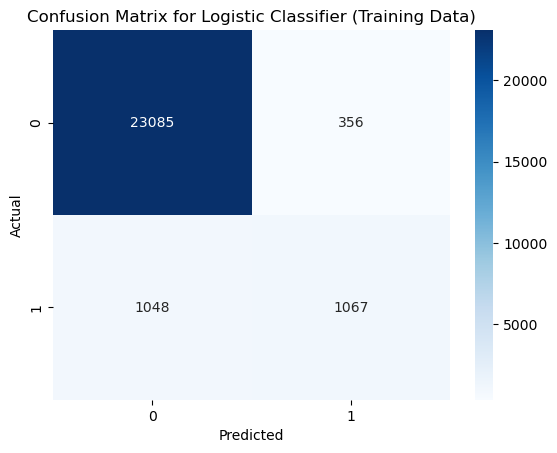

In [8]:
#Plot confusion matrix
cm_train = confusion_matrix(y_train, y_pred_train)

# Plot confusion matrix using seaborn
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title("Confusion Matrix for Logistic Classifier (Training Data)")
plt.show()

## Step 5: Test Set Predictions and Model Evaluation
Now let's take our trained logistic classifier and make predictions on the test set. Calculate the accuracy and confusion matrix. Then use `sns.heatmap` for improved confusion matrix visualization.

In [9]:
y_pred_test = model.predict(X_test_scaled)

# Print evaluation metrics
print(f"Accuracy: {accuracy_score(y_test, y_pred_test)}")

Accuracy: 0.9401990322286131


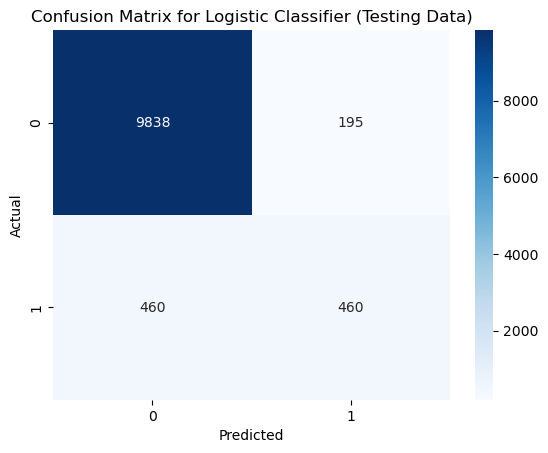

In [10]:
#Plot confusion matrix
cm = confusion_matrix(y_test, y_pred_test)

# Plot confusion matrix using seaborn
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title("Confusion Matrix for Logistic Classifier (Testing Data)")
plt.show()

## Step 6: Logistic Classifier Evaluation
How did your model perform on the unseen data? 
Does your model perform differently on observations of trees that survived vs trees that died?
Is there a class imbalance in this data set?

It performed about the same as its performance on the training data, but slightly better. There appears to be a class imbalance, with more "alive" (value = 0) trees. 

## Step 7: What about a Dummy?
What do you think would happen if we built a model that always predicts the majority class (dead trees)? How would its accuracy compare to your logistic regression model?

If we built a model that always predicts the majority class, it would perform even better. 

Let's go ahead and do it: use `DummyClassifier()` with the appropriate value for the 'strategy' parameter to train a majority classifier.  Then calculate this model's accuracy on the training data.

Dummy Accuracy: 0.9172405697292221

Dummy Confusion Matrix:


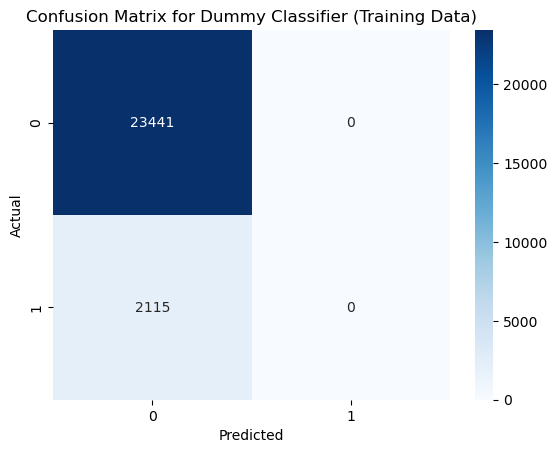

In [11]:
# Create a dummy classifier model
modelDum = DummyClassifier(strategy = 'most_frequent')

# Train the model
modelDum.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred_train_dum = modelDum.predict(X_train_scaled)

# Print accuracy and confusion matrix results
print(f"Dummy Accuracy: {accuracy_score(y_train, y_pred_train_dum)}")
print("\nDummy Confusion Matrix:")

cm = confusion_matrix(y_train, y_pred_train_dum)

# Plot confusion matrix using seaborn
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title("Confusion Matrix for Dummy Classifier (Training Data)")
plt.show()


# Step 8: ROCs and AUCs
Our two models have similar accuracy, but is that all there is to this story?  Let's dig a little deeper on the comparison of our logistic and dummy classifiers by examining the associated receiver-operator characteristic (ROC) curves. Calculate the area under the curve (AUC) for both models.

In [12]:
# Logistic classifier AUC
y_pred_prob = model.predict_proba(X_test_scaled)[:, 1]
auc = roc_auc_score(y_test, y_pred_prob)

print("Logistic AUC:", auc)

Logistic AUC: 0.9180671176422154


In [13]:
# Dummy classifier AUC
y_pred_prob_dum = modelDum.predict_proba(X_test_scaled)[:, 1]
auc_dum = roc_auc_score(y_test, y_pred_prob_dum)

print("Dummy AUC:", auc_dum)

Dummy AUC: 0.5


# Step 9: Plot dummy and logistic model ROC curves
Now using the outputs from `roc_curve()`, plot the ROC curves for both models on the same plot.  Make sure to use appropriate labels in the legend.

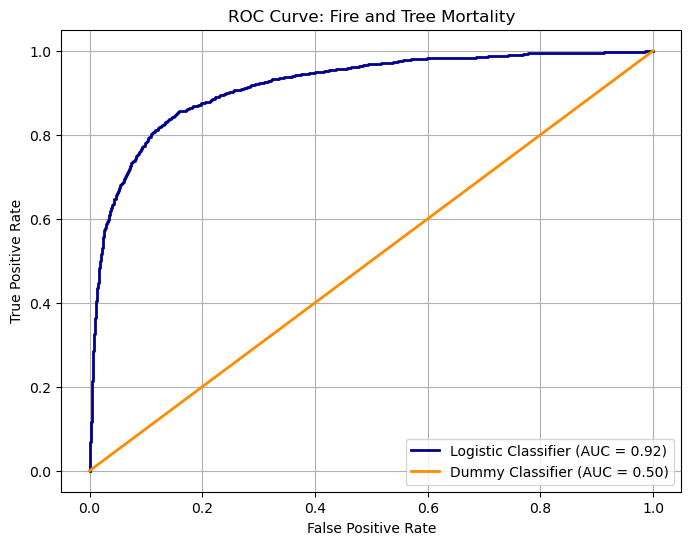

In [14]:
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
fpr_dum, tpr_dum, _ = roc_curve(y_test, y_pred_prob_dum) # _ is to ignore thresholds (the third output)

# Plot ROC surves
plt.figure(figsize = (8,6))
plt.plot(fpr, tpr, color = 'darkblue', lw = 2, label = f'Logistic Classifier (AUC = {auc:.2f})')
plt.plot(fpr_dum, tpr_dum, color = 'darkorange', lw = 2, label = f'Dummy Classifier (AUC = {auc_dum:.2f})') #label = f'ROC Curve (AUC = {roc_auc:.2f})
#plt.plot([0,1], [0,1], color = 'navy', lw = 2, linestyle = '--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Fire and Tree Mortality')
plt.legend()
plt.grid(True)
plt.show()

How do the two models compare on AUC?  What are the implications for evaluating classifiers based on accuracy of their predictions?

The two models differ dramatically by AUC. The logistic classifier has a much larger AUC than the dummy classifier despite having similar accuracy scores. This highlights the implications for evaluating classifiers solely on accuracy, as it masks the tradeoffs between a model making discrete choices and a model applying a blanket prediction irrespective of input.

# Step 10: Final interpretation

Identifying the most important features in a model can guide decision-making. For instance, in our dataset, highly important features might indicate key factors affecting tree survival after a fire. We will calculate the feature importance by examining the coefficients of our logistic regression model.

In [15]:
# Identify key factors affecting tree survival after a fire
importance_df = []

# Match feature names to coefficients
for feature, coef in zip(X.columns, model.coef_[0]):
    importance_df.append((feature, coef))

# Print the dataframe
print(importance_df)

[('YrFireName', -0.6604967854199928), ('Times_burned', 0.0), ('Species', 0.5415094899460164), ('Genus_species', -0.06786695710265969), ('DBH_cm', 0.42132369635836336), ('HT_m', -1.1654144218212206), ('CR_pre', 0.12341404880293343), ('CR_post', -2.4949744225411186)]


Which are the most important features in our model (reference the metadata to help answer this)? Can you think of any implications for forest management or conservation strategy?

Based on the magnitude of the coefficients, I would say that the most important features in our model are `CR_post` (post-fire live crown ratio) and `HT_m` (pre-fire tree height). As far as forest management implications, `CR_post` isn't very helpful in exploring *preventative* measures, but `HT_m` sheds some light on tree survivability based on height. Since the coefficient for `HT_m` is negative, there appears to be higher survivorship associated with shorter trees. Therefore, it may be beneficial to conserve shorter trees, as we can anticipaite that they are more likely to survive a forest fire.